# Arguments

In [1]:
# inceptionv3-ft-pv-self-eb,ap,lm,ct

num_of_epochs = 100
batch_size = 32
dataset_path_plantvillage = '../datasets/plantvillage'
dataset_path_self = '../datasets/self'
dataset_path_validation = '../datasets/validation'

dataset_paths = [dataset_path_plantvillage, dataset_path_self, dataset_path_validation]

final_model_path= 'model-final.h5'

input_width = 299
input_height = 299
input_depth = 3


# Select training classes

In [2]:
class_paths_validation = ['../datasets/self/___Early_blight', '../datasets/self/___Appids', '../datasets/self/___Leaf_miner', '../datasets/self/___Curly_top_virus']

# Load dataset

In [3]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image   import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.layers import Input
from keras.models import Model
from keras .applications import VGG16
from keras.optimizers import SGD
from keras.models import Model
from imutils import paths
import numpy as np
import os

import sys
sys.path.append('..')

from utils.preprocessors.resize_image_preprocessor import resizeImagePreprocessor
from utils.preprocessors.img_to_array_preprocessor import ImgToArrayPreprocessor
from utils.io.dataset_loader import DatasetLoader

# construct the image generator for data augmentation
aug = ImageDataGenerator(   rotation_range=30,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.2,
                            zoom_range=0.2,
                            horizontal_flip=True,
                            fill_mode='nearest')

def load_datasets(path_list):
    # Load image paths
    image_paths = []
    print("[INFO] loading images...")
    for path in path_list:
        image_paths.extend(list(paths.list_images(path)))
        
    # Get unique classnames

    class_names = [pt.split(os.path.sep)[-2] for pt in image_paths]
    class_names = [str(x) for x in np.unique(class_names)]

    # Initial image preprocessing
    aap = resizeImagePreprocessor(input_width, input_height)
    iap= ImgToArrayPreprocessor()

    #Load image data and perform image data preprocessing
    dl = DatasetLoader(preprocessors=[aap,iap])
    (data,labels)  = dl.load(image_paths,verbose=500)
    data = data.astype("float") / 255.0


    # train test split
    (train_x,test_x,train_y,test_y) = train_test_split(data,labels,test_size=0.25,random_state=42)

    # convert the labels from integers to vectors
    train_y = LabelBinarizer().fit_transform(train_y)
    test_y = LabelBinarizer().fit_transform(test_y)
    
    return (train_x,test_x,train_y,test_y, class_names)

(train_x,test_x,train_y,test_y, class_names) = load_datasets(class_paths_validation)



Using TensorFlow backend.


[INFO] loading images...
[INFO]: Processed 500/4401
[INFO]: Processed 1000/4401
[INFO]: Processed 1500/4401
[INFO]: Processed 2000/4401
[INFO]: Processed 2500/4401
[INFO]: Processed 3000/4401
[INFO]: Processed 3500/4401
[INFO]: Processed 4000/4401


In [4]:
print(len(class_names))
print(class_names)

4
['___Appids', '___Curly_top_virus', '___Early_blight', '___Leaf_miner']


# Load model from disk

In [5]:
# import tensorflow as tf
# print(tf.__version__)


# model = tf.keras.models.load_model(
#     final_model_path,
#     custom_objects=None,
#     compile=False
# )

from keras.models import load_model

model = load_model(final_model_path)

# Evaluate

In [6]:
from sklearn.metrics import classification_report

print("[INFO] evaluating after initialization...")
predictions = model.predict(test_x,batch_size=batch_size)

print(classification_report(test_y.argmax(axis =1),
                            predictions.argmax(axis =1),
                            target_names=class_names, 
                            digits=4))

[INFO] evaluating after initialization...
                    precision    recall  f1-score   support

         ___Appids     0.8669    0.9918    0.9251       243
___Curly_top_virus     0.9750    0.3578    0.5235       109
   ___Early_blight     0.8736    0.9974    0.9314       388
     ___Leaf_miner     0.9824    0.9252    0.9529       361

          accuracy                         0.9092      1101
         macro avg     0.9245    0.8180    0.8332      1101
      weighted avg     0.9178    0.9092    0.8967      1101



# Accuracy

In [7]:
ev = model.evaluate(test_x, test_y)
print(ev)

1101/1101 [==============================] - 10s 9ms/step
[0.23404700883565221, 0.9091734886169434]


In [8]:
acc = ev[1] * 100

print('accuracy : ' +  str("%.4f" % round(acc, 4)))

accuracy : 90.9173


# Confusion Matrix

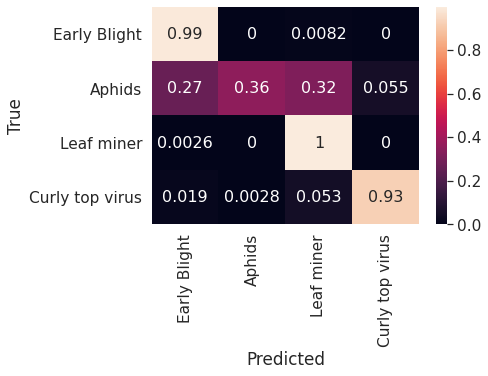

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

class_names = ['Early Blight', 'Aphids', 'Leaf miner', 'Curly top virus']

matrix = confusion_matrix(test_y.argmax(axis=1), predictions.argmax(axis=1))
matrix_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

df_cm = pd.DataFrame(matrix_normalized, range(len(class_names)), range(len(class_names)))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, xticklabels=class_names, yticklabels=class_names) # font size


# Add axis labels
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

# x is predicted
# y is true
